# Resources

* [Beginnner tutorial](https://www.tensorflow.org/get_started/mnist/beginners)
* Convolutional networks in TF: [overview of CNNs and how they work in TF](https://www.tensorflow.org/tutorials/layers) and [short version](https://www.tensorflow.org/get_started/mnist/pros)
* [ConvNetJS](https://cs.stanford.edu/people/karpathy/convnetjs/demo/mnist.html): good for visualising weights. The network configuration is pasted below
* [FastAI Course](http://course.fast.ai/): Not Tensorflow (uses Theano and Keras)

NB: I installed TensorFlow with pip in a virtualenv on OSX; I had problems with `protobuf` and had to remove it from the pip virtualenv and use Homebrew to install it instead. To make Homebrew packages available in the virtualenv install, put the `.pth` file the `protobuf` brew recipe generates in the `site-packages` directory of the virtual environment.

ConvnetJS settings for the CNN defined below:

    layer_defs = [];
    layer_defs.push({type:'input', out_sx:24, out_sy:24, out_depth:1});
    layer_defs.push({type:'conv', sx:5, filters:32, stride:1, pad:2, activation:'relu'});
    layer_defs.push({type:'pool', sx:2, stride:2});
    layer_defs.push({type:'conv', sx:5, filters:64, stride:1, pad:2, activation:'relu'});
    layer_defs.push({type:'pool', sx:2, stride:2});
    layer_defs.push({type:'softmax', num_classes:10});

    net = new convnetjs.Net();
    net.makeLayers(layer_defs);

    trainer = new convnetjs.SGDTrainer(net, {method:'adadelta', batch_size:20, l2_decay:0.001});


# Basic softmax regression

From [this guide in the TensorFlow docs](https://www.tensorflow.org/get_started/mnist/pros)

In [1]:
import tensorflow as tf

Loading the data, already partitioned into training and test sets

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
import tensorflow as tf
sess = tf.InteractiveSession()

We flatten the 28x28 images into a 784 element vector with greyscale pixel values and regress that to a 10-element vector where each element has a probability of class membership assigned to it

In [5]:
x = tf.placeholder(tf.float32, shape=[None, 784])

In [6]:
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [7]:
W = tf.Variable(tf.zeros([784,10]))

In [8]:
b = tf.Variable(tf.zeros([10]))

In [9]:
sess.run(tf.global_variables_initializer())

In [10]:
y = tf.matmul(x,W) + b

In [11]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=y))

In [12]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [13]:
for _ in range(100):
    batch = mnist.train.next_batch(100)
    train_step.run(feed_dict={x:batch[0],y_:batch[1]})

In [14]:
correct = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

In [15]:
accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))

In [16]:
print(accuracy.eval(feed_dict={x:mnist.test.images,y_: mnist.test.labels}))

0.8856


# Convolutional Example

In [17]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [18]:
def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides = [1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding = 'SAME')


Layer 1: 5x5 convolution, 32 output layers

In [19]:
W_conv1 = weight_variable([5,5,1,32])

In [20]:
b_conv1 = bias_variable([32])

In [21]:
x_image = tf.reshape(x,[-1,28,28,1])

In [22]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

This gives us 32 28x28 images for a single example. We shrink that by pooling adjacent cells into 32 smaller 14x14 images

In [23]:
h_pool1 = max_pool_2x2(h_conv1)

Layer 2: 5x5 convolution, 64 output layers, 14x14 outputs

In [24]:
W_conv2 = weight_variable([5,5,32,64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

Again we shrink this down, giving us 64 7x7 images

Now we lay the images out into a long vector of 3136 values and map them to 1024 values

In [25]:
W_fc1 = weight_variable([7*7*64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2,[-1,7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat,W_fc1) + b_fc1)

We add dropout for scalablility (also good for overfitting)

In [26]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

Now we go from 1024 values to 10 - these 10 are our labels so we'll have a vector of class probabilities (eventually)

In [27]:
W_fc2 = weight_variable([1024,10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

We want to minimise the difference between the predicted outputs and the actual outputs, using softmax ($\mathrm{arg} \max \frac{e^x}{\sum_{x' \in X}e^{x'}}$)

In [28]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

The optimiser uses gradients which are magically computed from the graph

In [29]:
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

We're minimising loss which is abstract, so we calculate the accuracy (mean proportion of predicted == value)

In [30]:
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [31]:
sess.run(tf.global_variables_initializer())

Loading and training is handled by the `mnist` package - presumably it's straight forward to implement an iterator for your own data.

In [32]:
for i in range(1000):
    batch = mnist.train.next_batch(50)
    if i % 100 == 0:
        train_accuracy = accuracy.eval(feed_dict ={x:batch[0],y_:batch[1],keep_prob:1.0})
        print("Step %d Training accuracy is %g"%(i,train_accuracy))
    train_step.run(feed_dict={x:batch[0],y_:batch[1],keep_prob:0.5})

print("Test Accuracy:%g"%accuracy.eval(feed_dict={x:mnist.test.images,y_:mnist.test.labels,keep_prob:1.0}))

Step 0 Training accuracy is 0.04
Step 100 Training accuracy is 0.86
Step 200 Training accuracy is 1
Step 300 Training accuracy is 0.92
Step 400 Training accuracy is 0.94
Step 500 Training accuracy is 0.94
Step 600 Training accuracy is 0.96
Step 700 Training accuracy is 0.96
Step 800 Training accuracy is 0.92
Step 900 Training accuracy is 0.92
Test Accuracy:0.9635


In [33]:
print("Test Accuracy:%g"%accuracy.eval(feed_dict={x:mnist.test.images,y_:mnist.test.labels,keep_prob:1.0}))

Test Accuracy:0.9635


In [34]:
import matplotlib.pyplot as plt

In [35]:
str(W_fc2)

"<tf.Variable 'Variable_8:0' shape=(1024, 10) dtype=float32_ref>"

In [36]:
tf.trainable_variables()

[<tf.Variable 'Variable:0' shape=(784, 10) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=(5, 5, 1, 32) dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'Variable_4:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variable 'Variable_5:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'Variable_6:0' shape=(3136, 1024) dtype=float32_ref>,
 <tf.Variable 'Variable_7:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'Variable_8:0' shape=(1024, 10) dtype=float32_ref>,
 <tf.Variable 'Variable_9:0' shape=(10,) dtype=float32_ref>]

Use the `run` function of the session to evaluate a variable and get its contents.

In [37]:
weights_c1 = sess.run(W_conv1)


In [40]:
weights_c1.shape

(5, 5, 1, 32)

In [56]:
weights_c1[(4,4,0,4)]

0.060706105

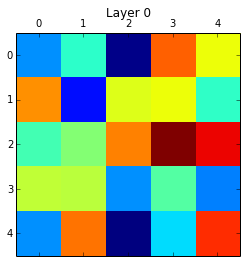

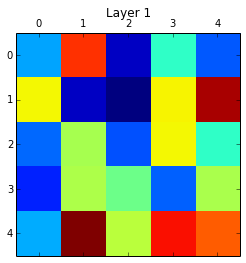

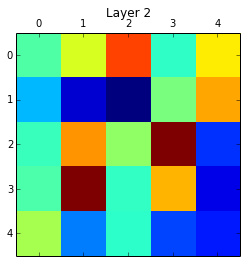

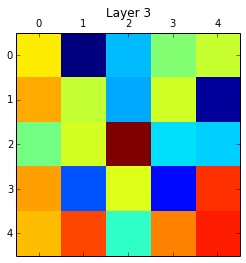

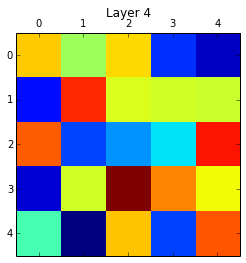

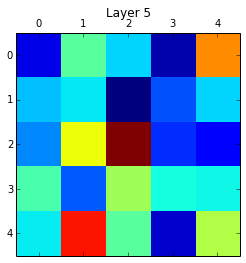

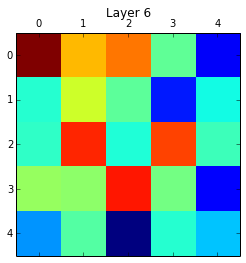

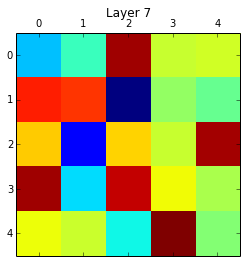

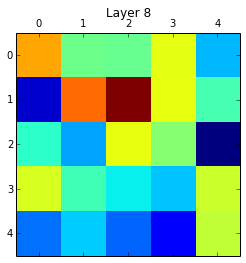

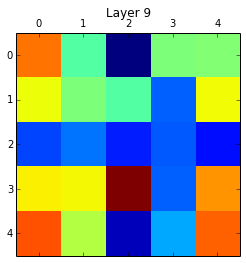

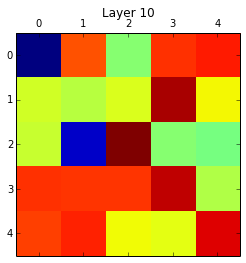

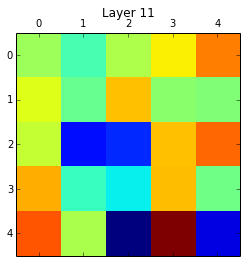

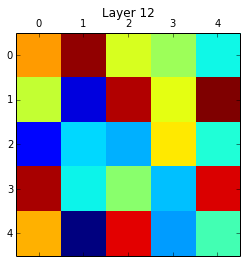

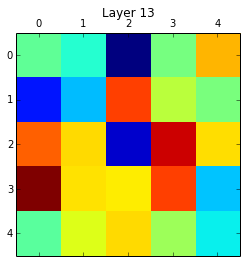

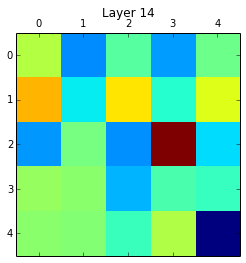

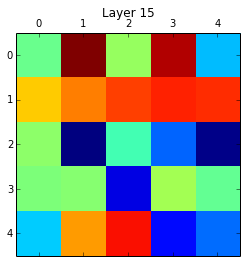

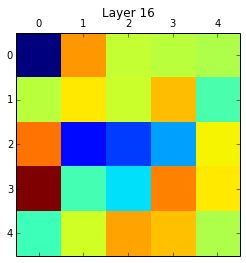

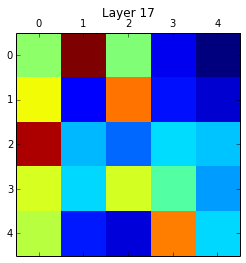

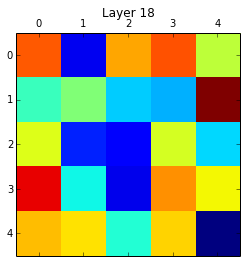

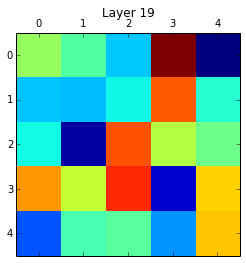

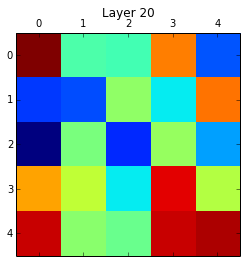

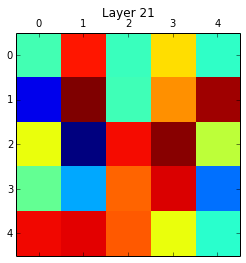

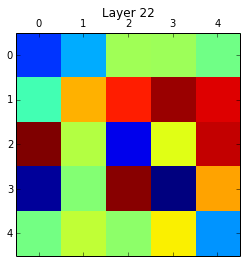

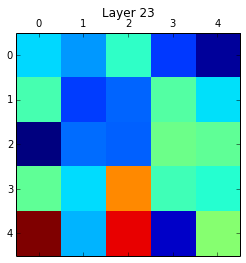

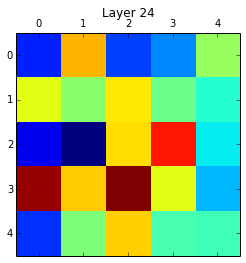

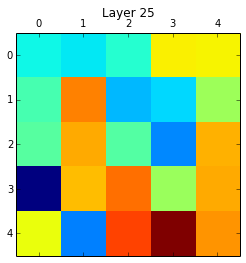

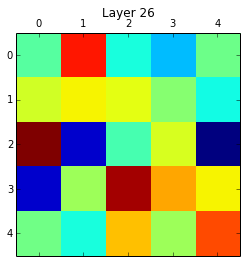

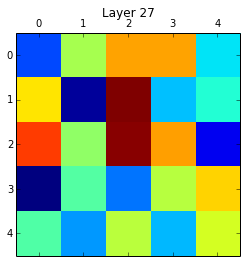

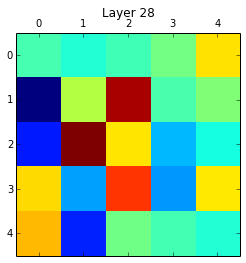

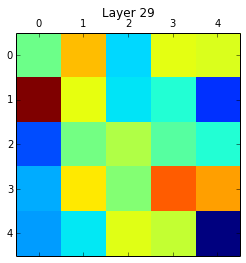

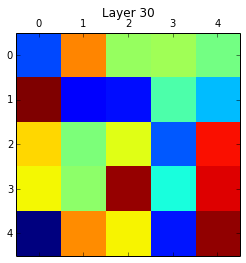

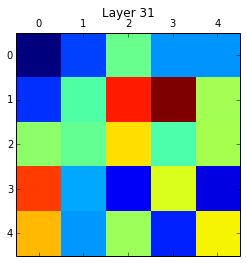

In [70]:
%matplotlib inline 
#plt.figure(1)

for layer in range(0,32):
#    plt.subplot(211 + layer)
    plt.matshow(weights_c1[:,:,0,layer])
    plt.title("Layer %d"%(layer))
    plt.show()

In [71]:
help(sess.run)

Help on method run in module tensorflow.python.client.session:

run(self, fetches, feed_dict=None, options=None, run_metadata=None) method of tensorflow.python.client.session.InteractiveSession instance
    Runs operations and evaluates tensors in `fetches`.
    
    This method runs one "step" of TensorFlow computation, by
    running the necessary graph fragment to execute every `Operation`
    and evaluate every `Tensor` in `fetches`, substituting the values in
    `feed_dict` for the corresponding input values.
    
    The `fetches` argument may be a single graph element, or an arbitrarily
    nested list, tuple, namedtuple, dict, or OrderedDict containing graph
    elements at its leaves.  A graph element can be one of the following types:
    
    * An @{tf.Operation}.
      The corresponding fetched value will be `None`.
    * A @{tf.Tensor}.
      The corresponding fetched value will be a numpy ndarray containing the
      value of that tensor.
    * A @{tf.SparseTensor}.
    